In [1]:
# Data Augmentation
from CVAE import ConditionalVariationalAutoEncoder as CVAE
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

from functions import *
from metrics import *
from pipeline import *
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_contour,
    plot_slice,
)
import shap

import pandas as pd
import numpy as np
import seaborn as sn
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from collections import Counter
import torch
from torch import Tensor, tensor

# Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import os
import warnings
warnings.filterwarnings("ignore")
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

# Shear Wall Database

In [2]:
file_path = r'C:\Users\E2-415\Desktop\Databases\Shear_Wall_Database.xlsx'
df1 = pd.read_excel(file_path, sheet_name='Database')
df=df1.loc[:, 'FailureMode':'Ab/Ag']
df.head()

FailureMode  M/Vlw      lw/tw  ρvwFy,vw/fc  ρhwFy,hw/fc  ρvbFy,vb/fc  \
0            1    1.1  10.714286     0.268879     0.136711     0.348231   
1            1    1.1  10.714286     0.262358     0.133396     0.339785   
2            1    1.1  10.714286     0.346364     0.176108     0.448584   
3            1    1.1  10.714286     0.334023     0.169834     0.432601   
4            1    1.1  10.714286     0.324766     0.165127     0.420612   

   ρhbFy,hb/fc    P/fcAg Section  Ab/Ag  
0     0.149140  0.000000       R    0.0  
1     0.145522  0.102168       R    0.0  
2     0.192118  0.208187       R    0.0  
3     0.185273  0.000000       R    0.0  
4     0.180139  0.101727       R    0.0

In [3]:
df.groupby('FailureMode').size()

FailureMode
1    152
2     96
3    122
4     23
dtype: int64

In [4]:
print_ranges(df)

                  Min       Max
FailureMode         1         4
M/Vlw        0.249869       4.1
lw/tw        4.347826      57.0
ρvwFy,vw/fc       0.0  0.487957
ρhwFy,hw/fc       0.0  0.326964
ρvbFy,vb/fc       0.0  2.645968
ρhbFy,hb/fc       0.0  1.264049
P/fcAg            0.0  0.499402
Section             B         R
Ab/Ag             0.0  0.443262


In [5]:
feature=df.loc[:, df.columns != 'FailureMode']
output=df['FailureMode'] - 1
class_names = ["F", "FS", "S", "SL"]

feature_tensor, label_tensor, len_numerical, len_ohes, additional_info = process_dataframe(feature, output, scaler = 'standard')

print("Processed Feature:")
print(feature_tensor)

print("Processed Label:")
print(label_tensor)

print("\nLength of Numerical Columns:")
print(len_numerical)

print("\nLength of Categorical Columns:")
print(len_ohes)

data = (len_numerical, len_ohes, additional_info)
save_results(data, "preprocess.pkl")

Processed Feature:
tensor([[-0.4065, -0.4579,  2.5459,  ...,  0.0000,  0.0000,  1.0000],
        [-0.4065, -0.4579,  2.4566,  ...,  0.0000,  0.0000,  1.0000],
        [-0.4065, -0.4579,  3.6069,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.8601, -0.6169, -0.4257,  ...,  0.0000,  0.0000,  1.0000],
        [-0.5473, -0.1562, -0.3689,  ...,  0.0000,  0.0000,  1.0000],
        [-0.5473, -0.1562, -0.4049,  ...,  0.0000,  0.0000,  1.0000]])
Processed Label:
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

Length of Numerical Columns:
8

Length of Categorical Columns:
[3]


# Generate Augmented dataset

In [6]:
X = feature_tensor
y_label = label_tensor # used to generate Data Augmentation using CVAE
y = torch.tensor(output.to_numpy(), dtype=torch.int)
N_fold = 20
save_path = "folds.pkl"

if os.path.exists(save_path):
    all_folds_dict = load_results(filename=save_path)
else:
    indices = np.arange(X.size(0))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=0)
    
    # Initialize all fold lists
    regular_folds = []
    smote_folds = []
    cvae_folds = []
    random_folds = []
    borderline_smote_folds = []
    svm_smote_folds = []
    adasyn_folds = []
    smotetomek_folds = []
    smoteenn_folds = []
    
    # CVAE Parameters
    label_scaler = additional_info['label_scaler']
    label_dim = additional_info['label_dim']
    layers_dim = [128, 64, 32, 3]  # Encoder and Decoder layer sizes
    batch_size = 32
    epochs = 500
    learning_rate = 5e-3
    num_var = len_numerical + sum(len_ohes)
    
    # Split dataset into train and test
    X_train, y_train_label, y_train = X[train_idx], y_label[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    # Regular Dataset (No oversampling)
    regular_folds.append((X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy()))
    regular_folds = [regular_folds[0]] * N_fold
    
    # SMOTE Dataset
    smote = SMOTE(random_state=0)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    smote_folds.append((X_smote, y_smote, X_test.numpy(), y_test.numpy()))
    smote_folds = [smote_folds[0]] * N_fold
    
    # CVAE Dataset
    set_random_seed(0)
    cvae = CVAE(len_numerical, len_ohes, label_dim,
                layers_dim=layers_dim, batch_norm=True, activation='relu')
    cvae.train_model(X_train, y_train_label, lr=learning_rate, batch_size=batch_size,
                     n_iter=epochs, beta_kl=0.5, beta_rec=1.0)
    X_cvae, y_cvae = cvae.resample(X_train, y_train_label, label_scaler)
    cvae_folds.append((X_cvae, y_cvae, X_test.numpy(), y_test.numpy()))
    cvae_folds = [cvae_folds[0]] * N_fold
    
    # RandomOverSampler Dataset
    ros = RandomOverSampler(random_state=0)
    X_ros, y_ros = ros.fit_resample(X_train, y_train)
    random_folds.append((X_ros, y_ros, X_test.numpy(), y_test.numpy()))
    random_folds = [random_folds[0]] * N_fold

    # ADASYN Dataset
    adasyn = ADASYN(random_state=0, sampling_strategy='minority')
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
    adasyn_folds.append((X_adasyn, y_adasyn, X_test.numpy(), y_test.numpy()))
    adasyn_folds = [adasyn_folds[0]] * N_fold
    
    # Create dictionary with all the folds
    all_folds_dict = {
        "regular": regular_folds,
        "random": random_folds,
        "smote": smote_folds,
        "adasyn": adasyn_folds,
        "cvae": cvae_folds
    }  
    save_results(all_folds_dict, filename=save_path)

# Pipeline

Running NB on regular folds


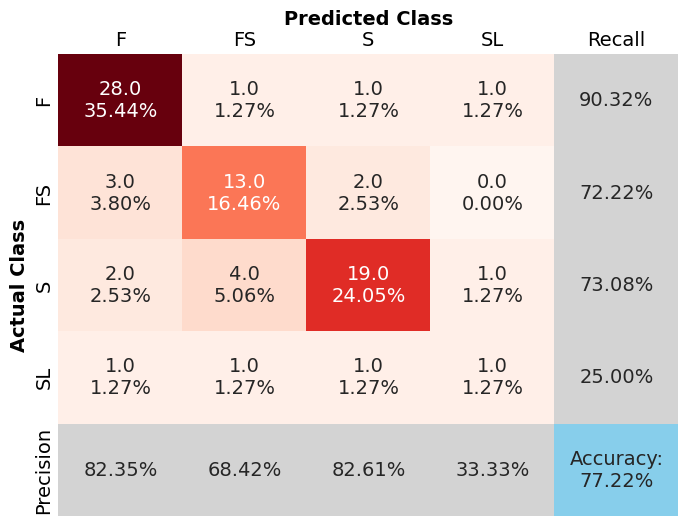

Running NB on random folds


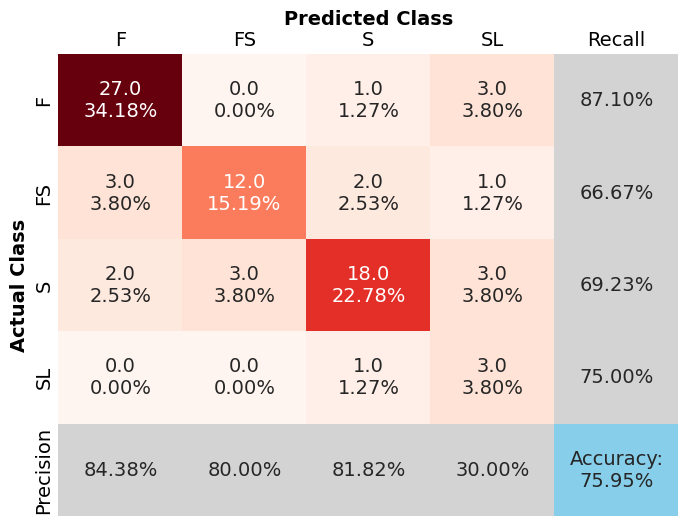

Running NB on smote folds


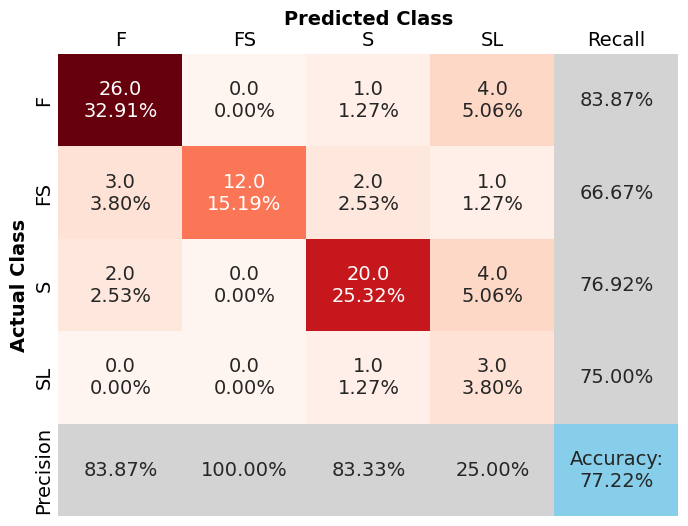

Running NB on adasyn folds


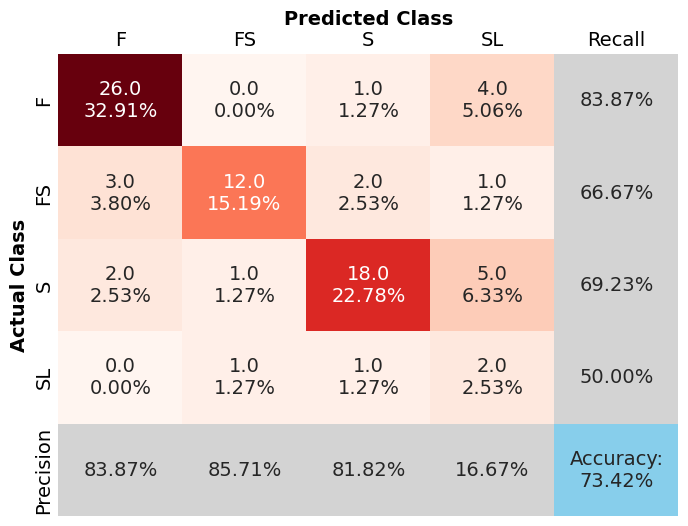

Running NB on cvae folds


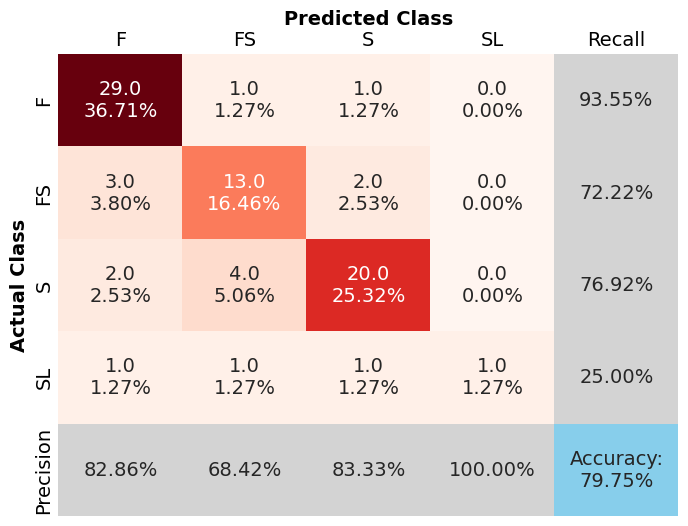

Running DT on regular folds


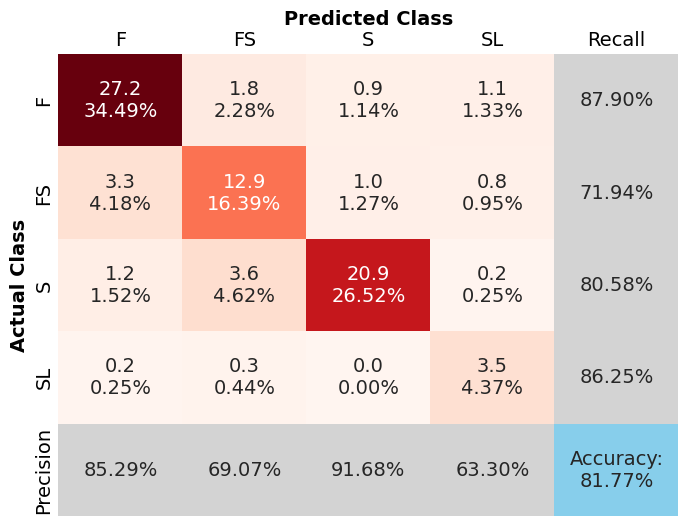

Running DT on random folds


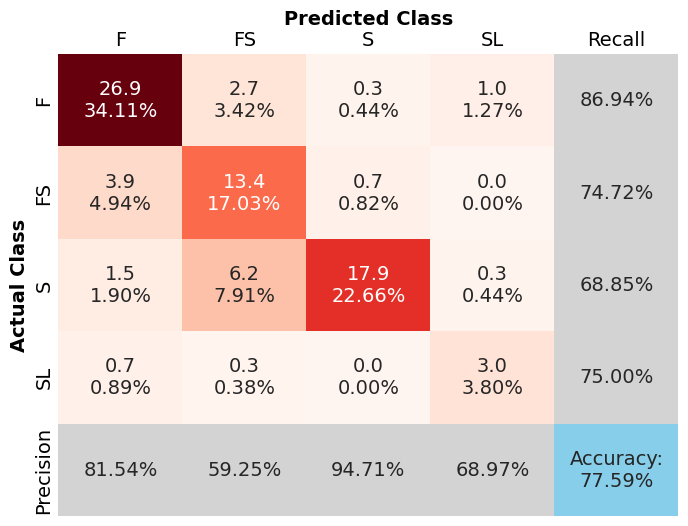

Running DT on smote folds


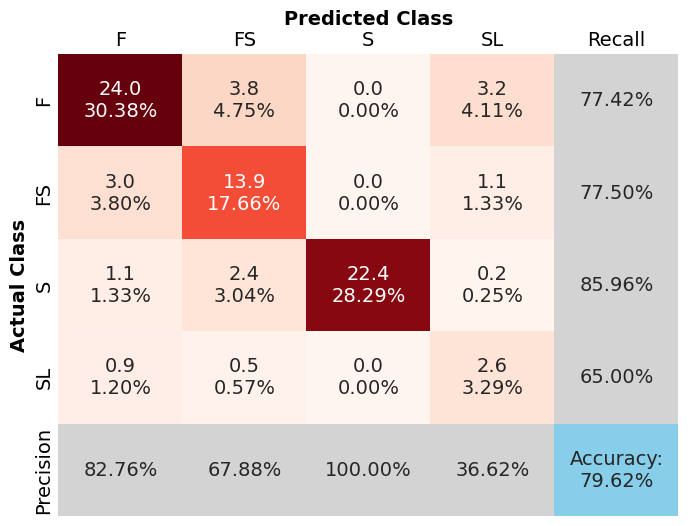

Running DT on adasyn folds


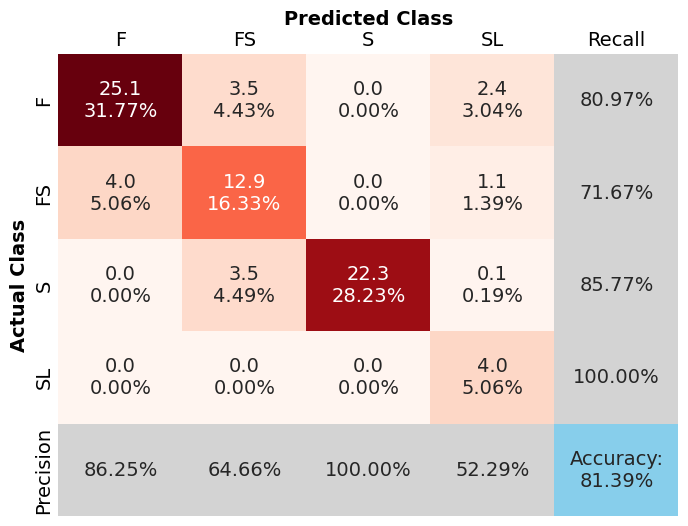

Running DT on cvae folds


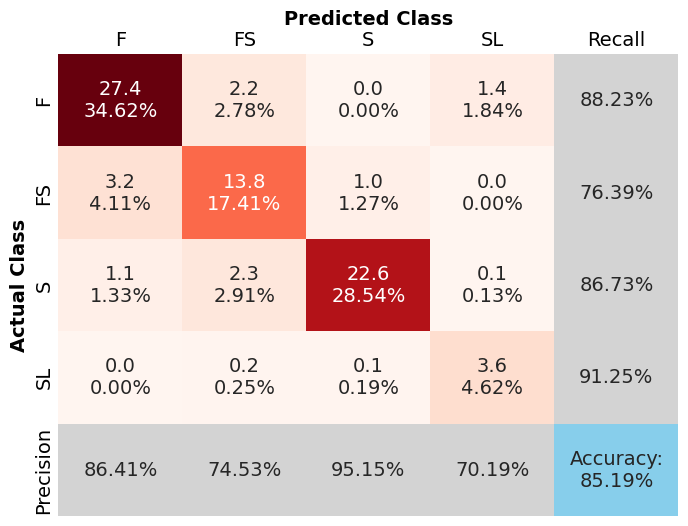

Running RF on regular folds


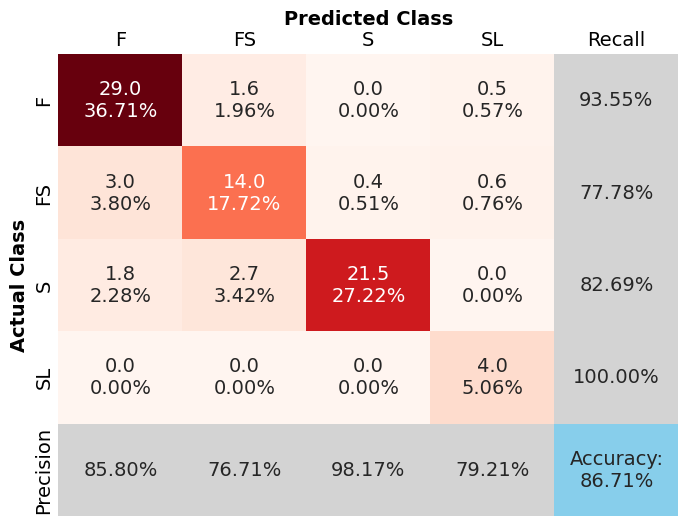

Running RF on random folds


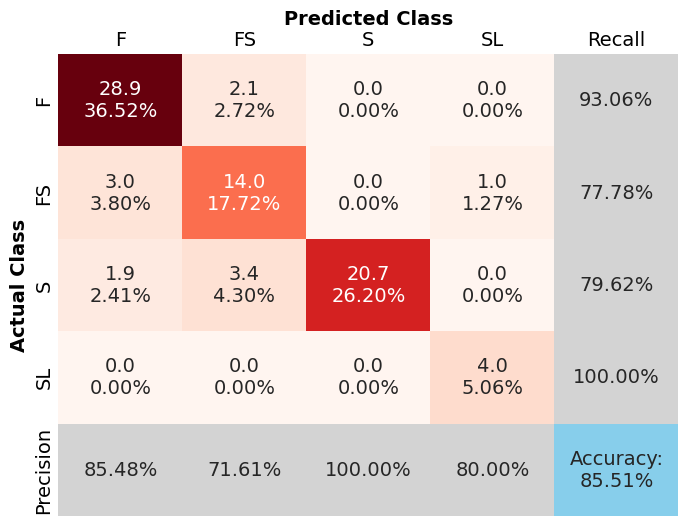

Running RF on smote folds


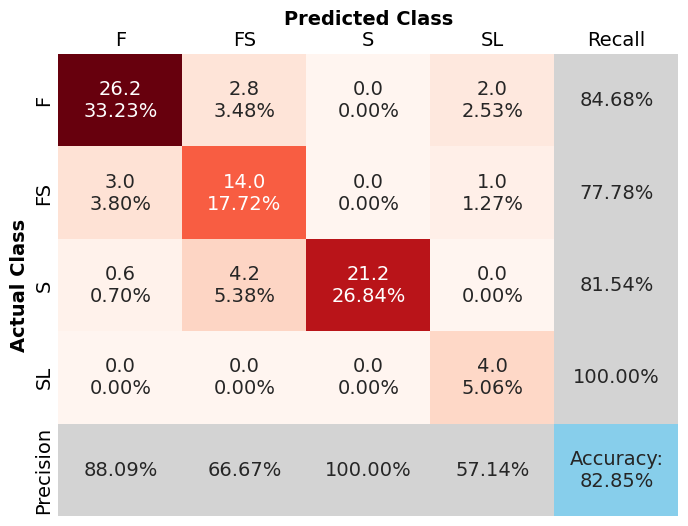

Running RF on adasyn folds


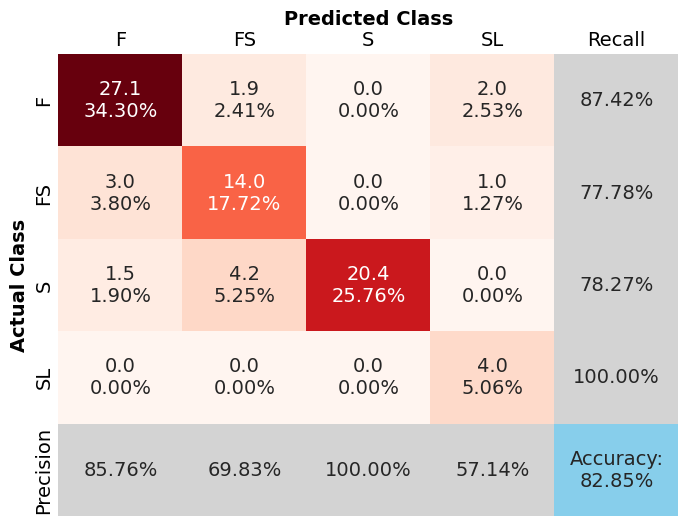

Running RF on cvae folds


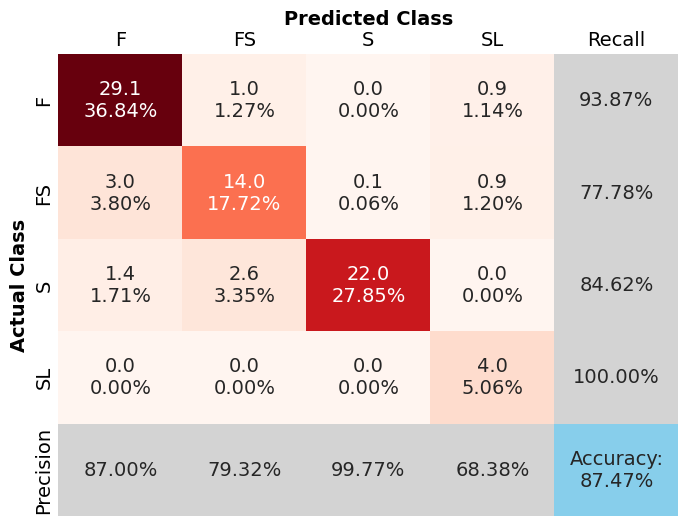

Running ET on regular folds


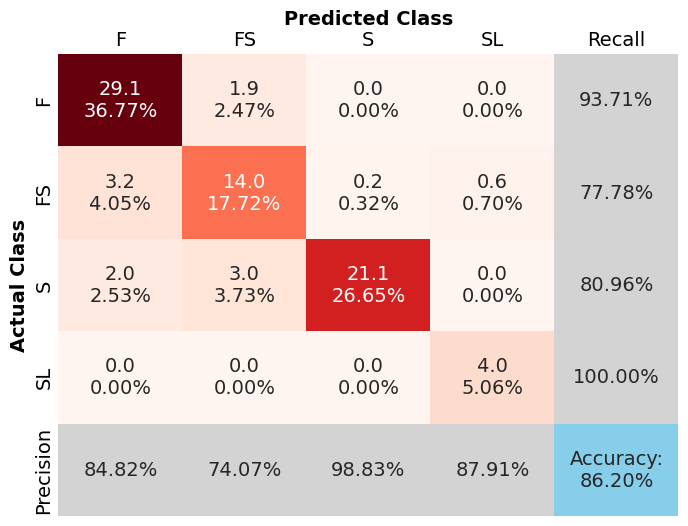

Running ET on random folds


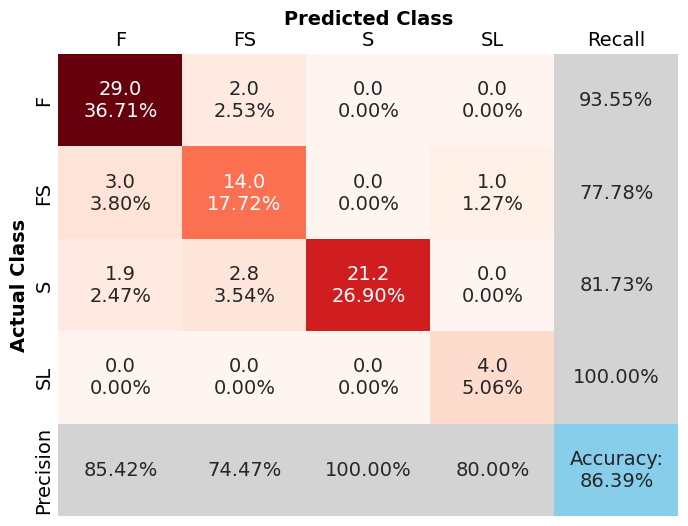

Running ET on smote folds


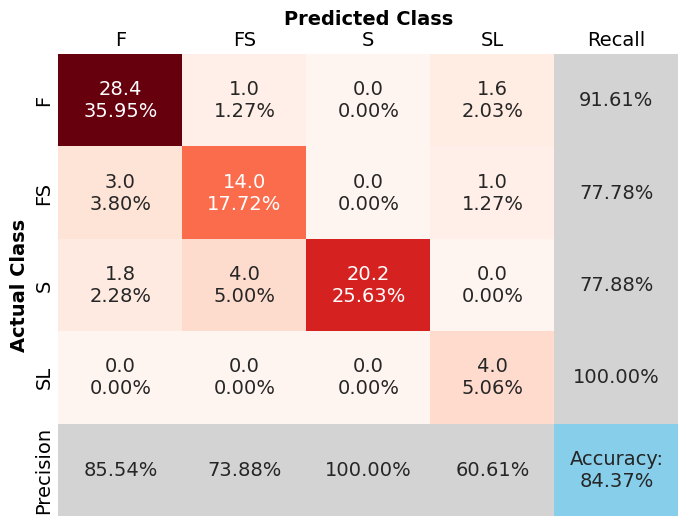

Running ET on adasyn folds


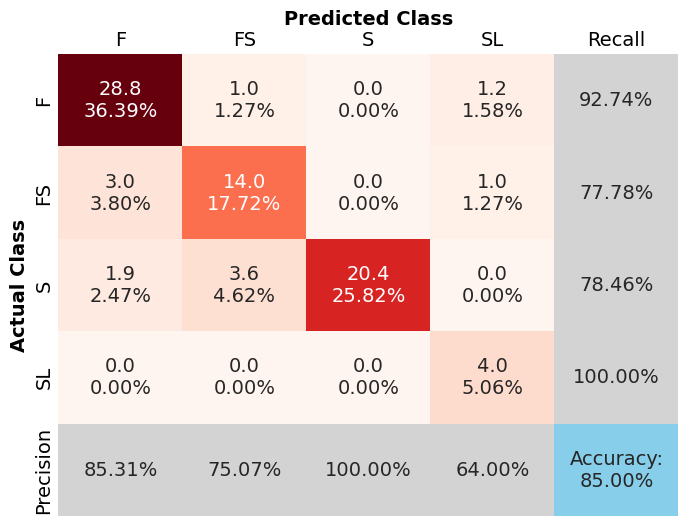

Running ET on cvae folds


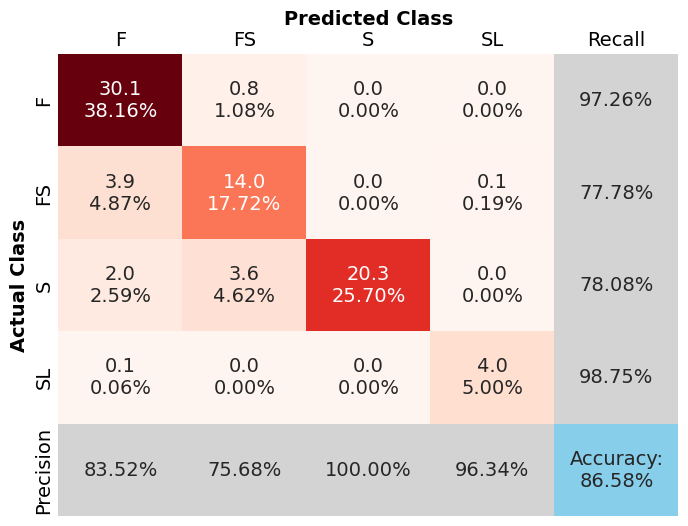

Running XGB on regular folds


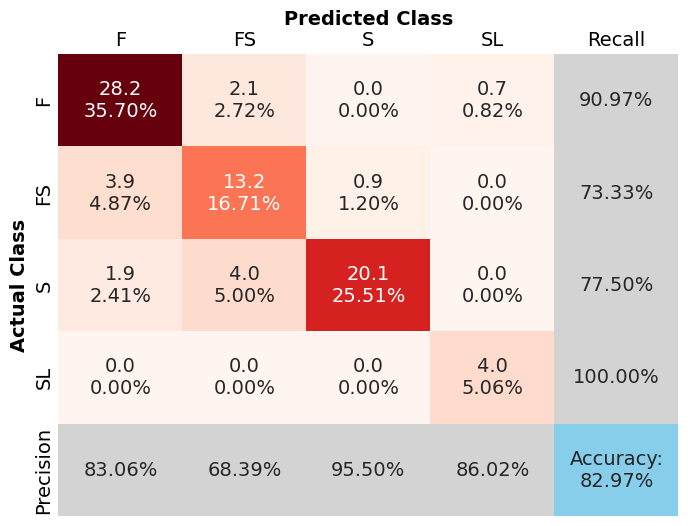

Running XGB on random folds


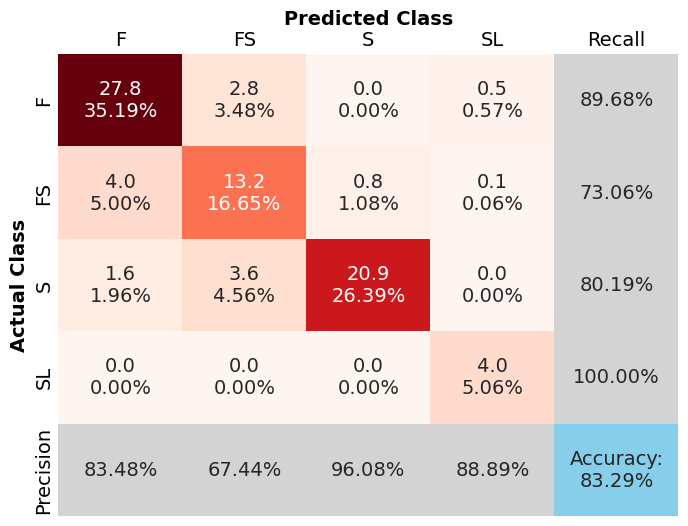

Running XGB on smote folds


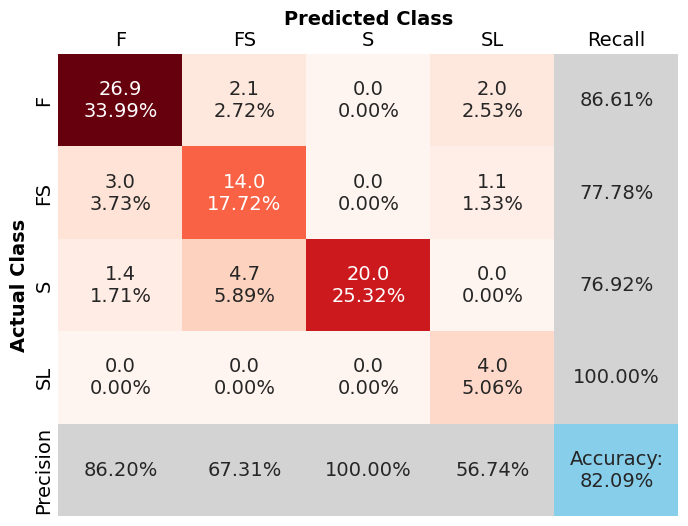

Running XGB on adasyn folds


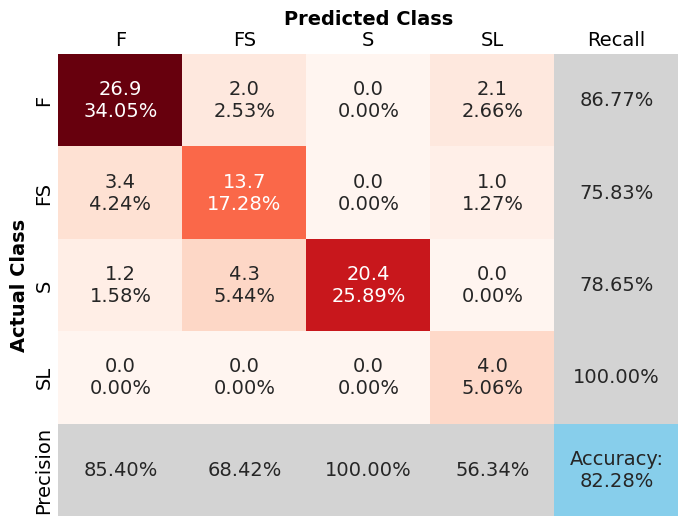

Running XGB on cvae folds


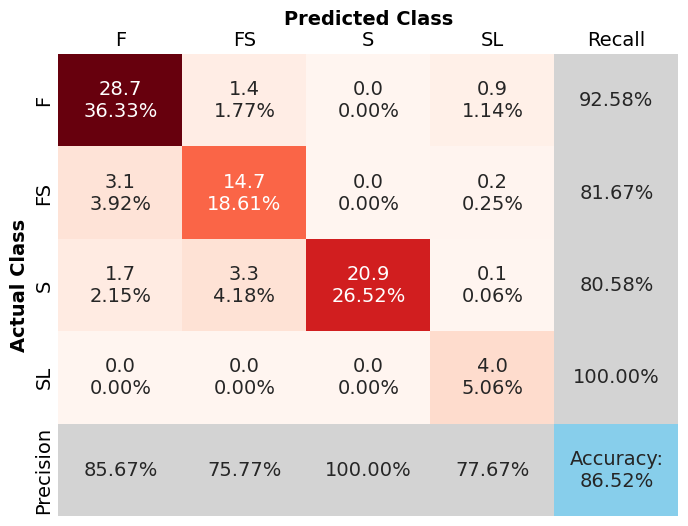

Running LGB on regular folds


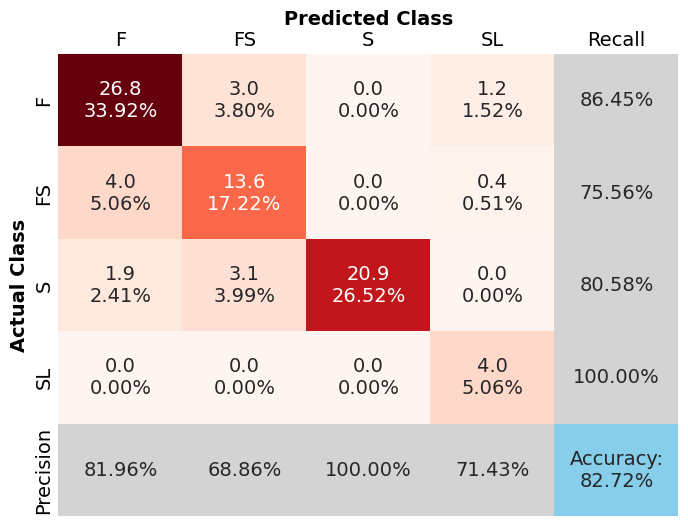

Running LGB on random folds


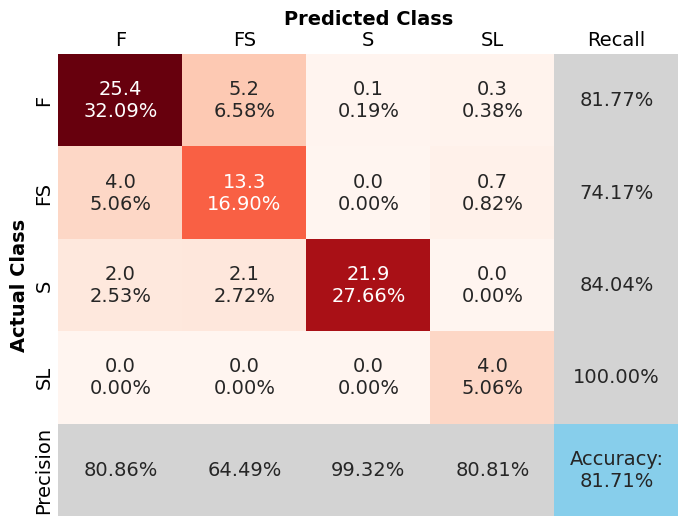

Running LGB on smote folds


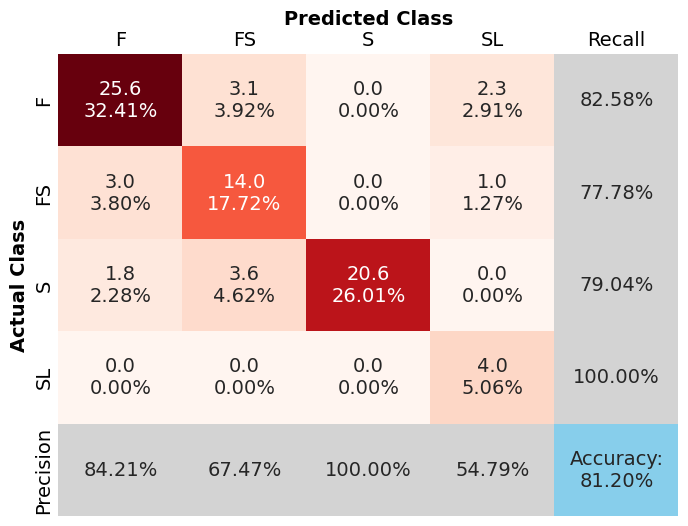

Running LGB on adasyn folds


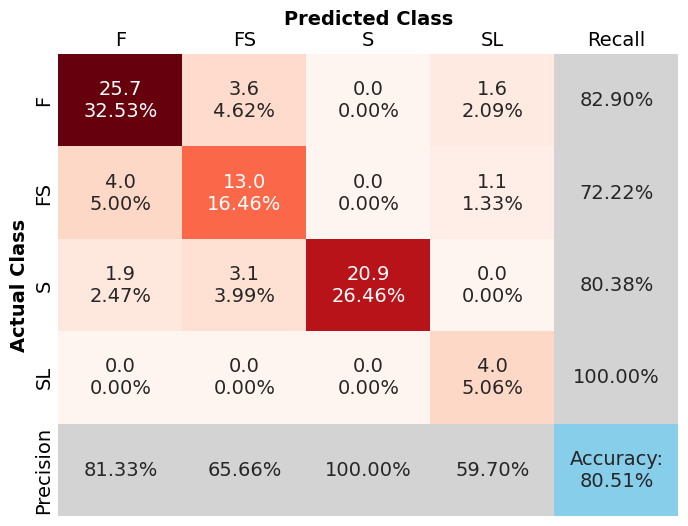

Running LGB on cvae folds


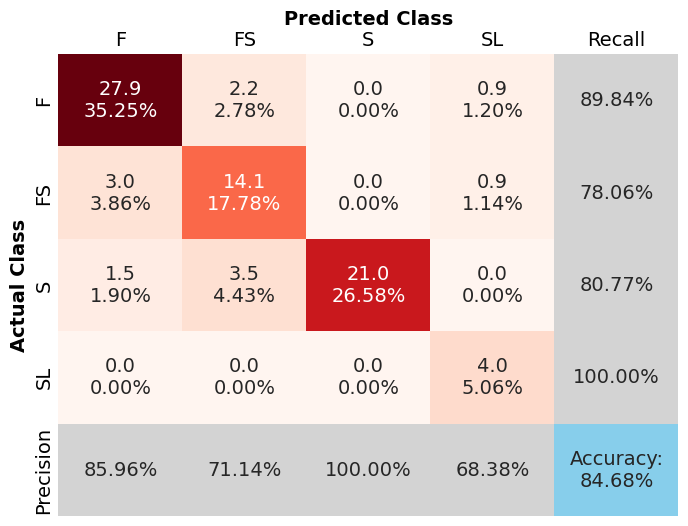

Running CB on regular folds


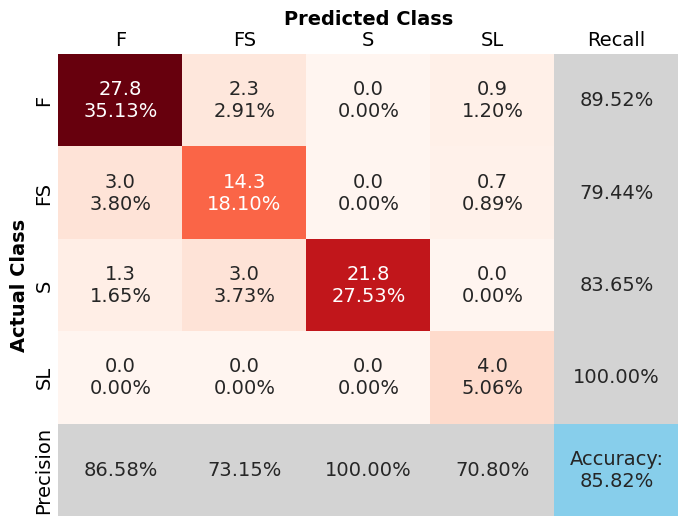

Running CB on random folds


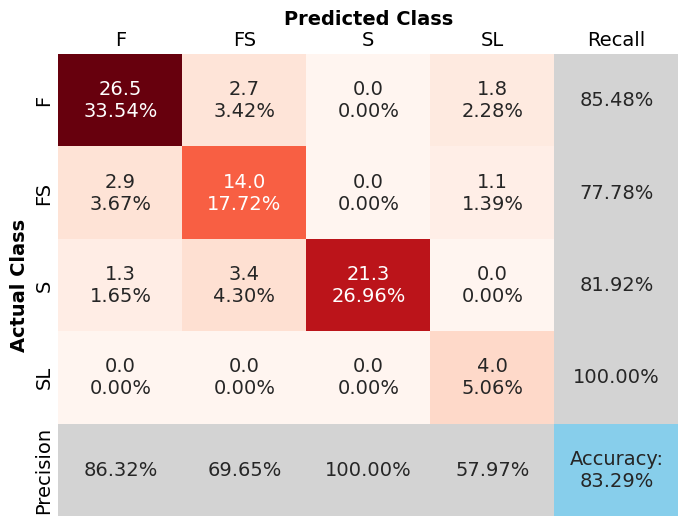

Running CB on smote folds


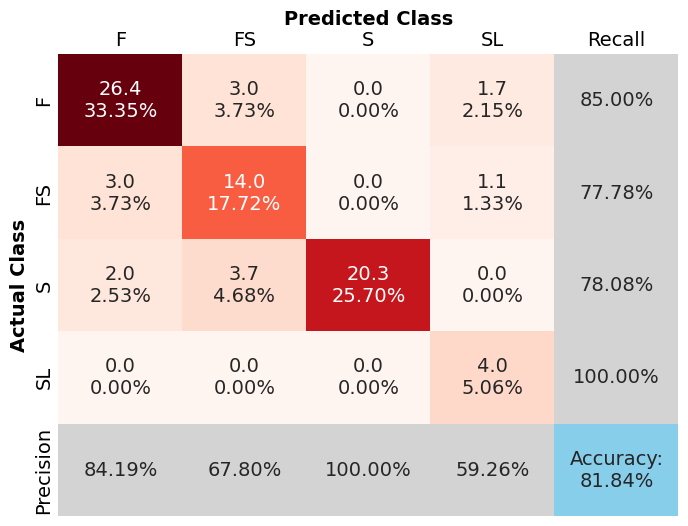

Running CB on adasyn folds


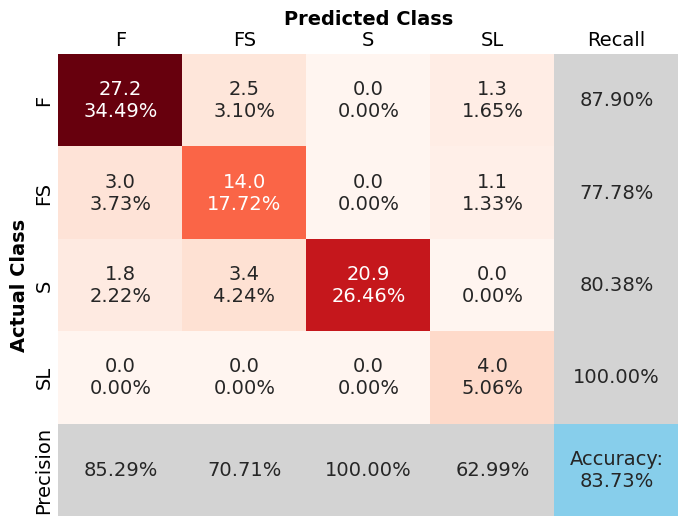

Running CB on cvae folds


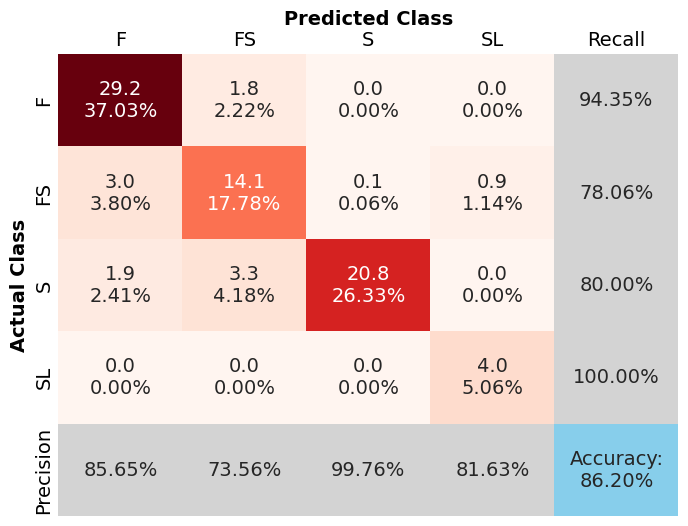

In [7]:
# Define models and folds
models = ["NB", "DT", "RF", "ET", "XGB", "LGB", "CB"]
methods = ["regular", "random", "smote", "adasyn", "cvae"]
folds_dict = {method: all_folds_dict[method] for method in methods if method in all_folds_dict}

# Run pipelines and save the results
results_dict = run_multiple_pipelines(models, folds_dict)
save_results(results_dict, filename="results_multiFolds_base.pkl")

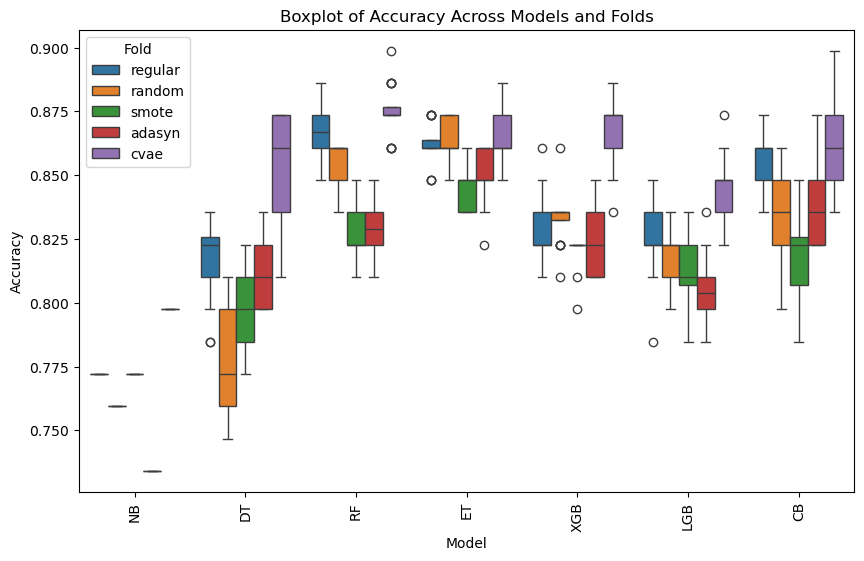

In [8]:
plot_metric_boxplot(results_dict, models, methods, metric="Accuracy")

In [9]:
result_df = summarize_results_table(results_dict, metrics=['Accuracy', 'Recall', 'Precision', 'F1-Score'], mode='best', 
                            model_order=["NB", "DT", "RF", "ET", "XGB", "LGB", "CB"], method_order=["regular", "random", "smote", "adasyn", "cvae"])

In [10]:
result_df

Model   Method  Accuracy  Recall  Precision  F1-Score  Avg Time (s)
0     NB  regular    0.7722  0.6516     0.6668    0.6564          1.78
1     NB   random    0.7595  0.7450     0.6905    0.6907          1.87
2     NB    smote    0.7722  0.7562     0.7305    0.7034          1.79
3     NB   adasyn    0.7342  0.6744     0.6702    0.6472          1.81
4     NB     cvae    0.7975  0.6692     0.8365    0.6954          1.78
5     DT  regular    0.8354  0.8641     0.8183    0.8362          3.83
6     DT   random    0.8101  0.7947     0.7996    0.7870          4.10
7     DT    smote    0.8228  0.7966     0.7347    0.7473          4.53
8     DT   adasyn    0.8354  0.8614     0.7969    0.8180          4.37
9     DT     cvae    0.8734  0.8972     0.8829    0.8809          4.48
10    RF  regular    0.8861  0.8995     0.9037    0.9010        231.17
11    RF   random    0.8608  0.8802     0.8485    0.8579        243.00
12    RF    smote    0.8481  0.8737     0.7929    0.8165        315.82
13    RF   adasyn    0.8481  0.8737     0.7982    0.8197        272.40
14    RF     cvae    0.8987  0.9060     0.9164    0.9093        295.90
15    ET  regular    0.8734  0.8899     0.9028    0.8933        155.31
16    ET   random    0.8734  0.8899     0.8577    0.8689        169.47
17    ET    smote    0.8608  0.8802     0.8243    0.8409        157.12
18    ET   adasyn    0.8608  0.8802     0.8243    0.8409        157.03
19    ET     cvae    0.8861  0.8979     0.9142    0.9030        146.06
20   XGB  regular    0.8608  0.8744     0.8835    0.8766        422.71
21   XGB   random    0.8608  0.8845     0.8918    0.8828        383.53
22   XGB    smote    0.8228  0.8560     0.7788    0.7991        394.39
23   XGB   adasyn    0.8481  0.8722     0.8104    0.8298        467.76
24   XGB     cvae    0.8861  0.9022     0.9081    0.9015        394.81
25   LGB  regular    0.8481  0.8737     0.8788    0.8716        100.75
26   LGB   random    0.8354  0.8672     0.8698    0.8658        126.06
27   LGB    smote    0.8354  0.8657     0.7867    0.8099        159.18
28   LGB   adasyn    0.8354  0.8598     0.8018    0.8207        117.33
29   LGB     cvae    0.8734  0.8883     0.8907    0.8845        135.09
30    CB  regular    0.8734  0.8957     0.8595    0.8728        797.13
31    CB   random    0.8608  0.8818     0.8232    0.8424       1585.91
32    CB    smote    0.8481  0.8722     0.8130    0.8313       6472.61
33    CB   adasyn    0.8734  0.8899     0.8248    0.8399        871.66
34    CB     cvae    0.8987  0.9075     0.8918    0.8901       1724.03

# SHAP

In [11]:
col_names = additional_info['numerical_cols']+additional_info['ohe_scalers'][0].categories_[0].tolist()

(X_train_cvae, y_train_cvae, _, _) = folds_dict['cvae'][0]
(X_train, y_train, X_test, y_test) = folds_dict['regular'][0]

X_train_df = pd.DataFrame(X_train, columns=col_names)
X_test_df = pd.DataFrame(X_test, columns=col_names)
X_train_cvae_df = pd.DataFrame(X_train_cvae, columns=col_names)

X_df = pd.concat([X_train_df, X_test_df])

X = X_df
rename_dict = {
    'M/Vlw': r'$M/Vl_{w}$',
    'lw/tw': r'$l_{w}/t_{w}$',
    'ρvwFy,vw/fc': r'$\rho_{vw}F_{y,vw}/f_{c}^\prime$',
    'ρhwFy,hw/fc': r'$\rho_{hw}F_{y,hw}/f_{c}^\prime$',
    'ρvbFy,vb/fc': r'$\rho_{vb}F_{y,vb}/f_{c}^\prime$',
    'ρhbFy,hb/fc': r'$\rho_{hb}F_{y,hb}/f_{c}^\prime$',
    'P/fcAg': r'$P/f_{c}^\prime A_{g}$',
    'Section': 'Section Shape',
    'Ab/Ag': r'$A_{b}/A_{g}$',
    'R': 'Rectangular',
    'B': 'Barbell',
    'F': 'Flanged'
}
X = X.rename(columns=rename_dict)

In [12]:
params = {'n_estimators': 425, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.25732930753297395}
model = RandomForestClassifier(**params, random_state=42)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)

## Regular

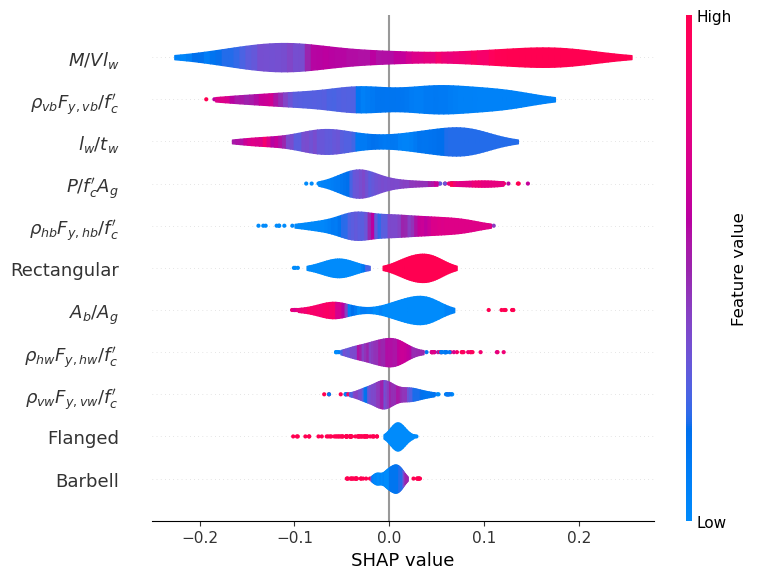

In [13]:
shap_values = explainer.shap_values(X)
shap_values_class = shap_values[..., 0]
shap.summary_plot(shap_values_class, X, plot_type="violin", show=False)
plt.xlabel("SHAP value")
plt.savefig("plots/regular_0.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

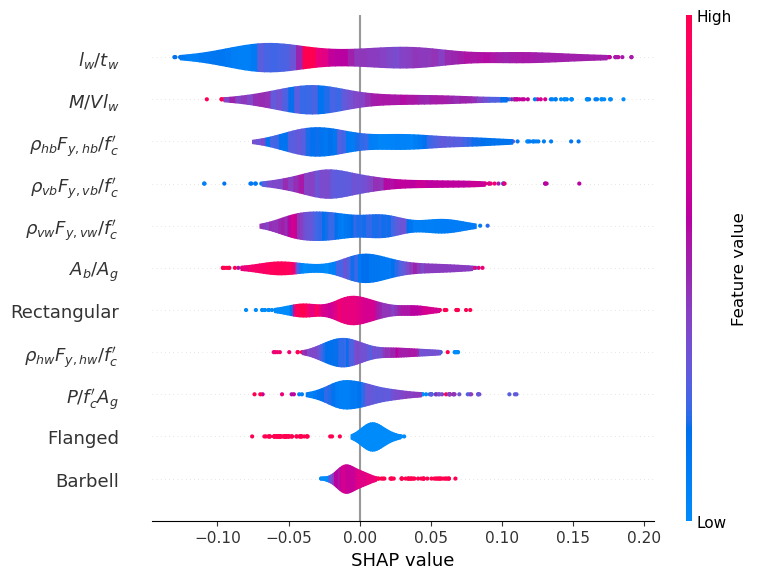

In [14]:
shap_values_class = shap_values[..., 1]
shap.summary_plot(shap_values_class, X, plot_type="violin", show=False)
plt.xlabel("SHAP value")
plt.savefig("plots/regular_1.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

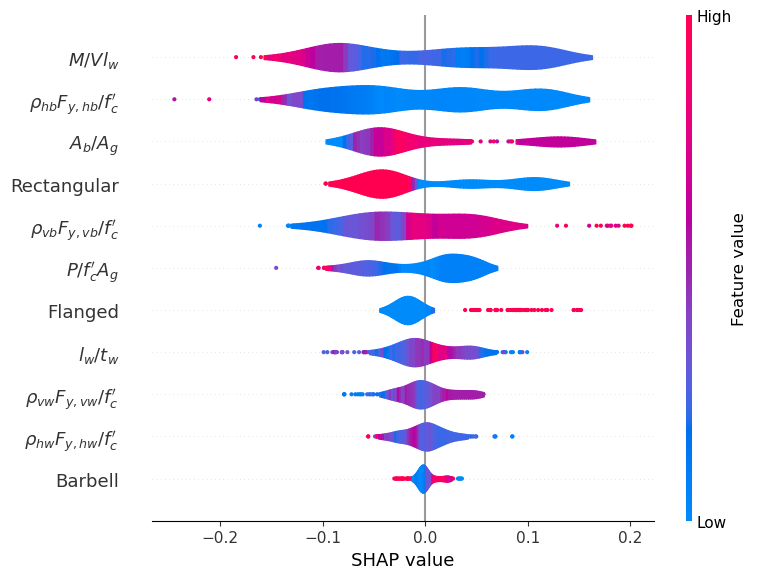

In [15]:
shap_values_class = shap_values[..., 2]
shap.summary_plot(shap_values_class, X, plot_type="violin", show=False)
plt.xlabel("SHAP value")
plt.savefig("plots/regular_2.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

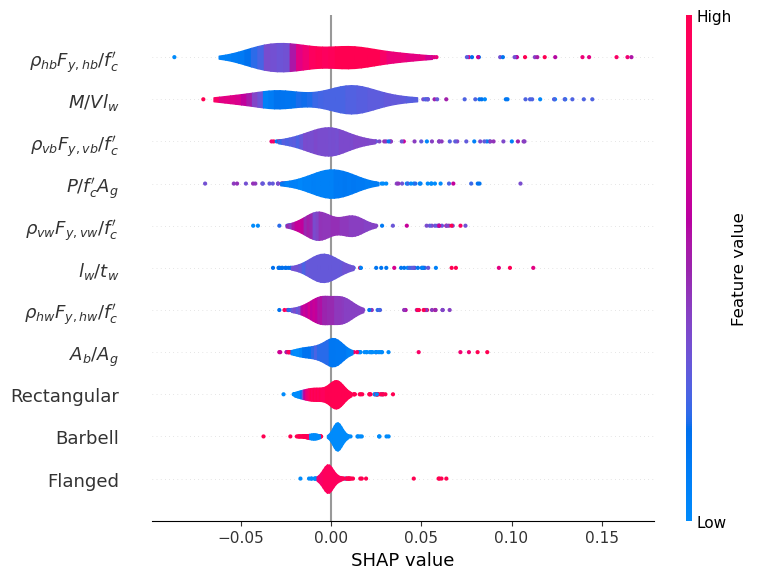

In [16]:
shap_values_class = shap_values[..., 3]
shap.summary_plot(shap_values_class, X, plot_type="violin", show=False)
plt.xlabel("SHAP value")
plt.savefig("plots/regular_3.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

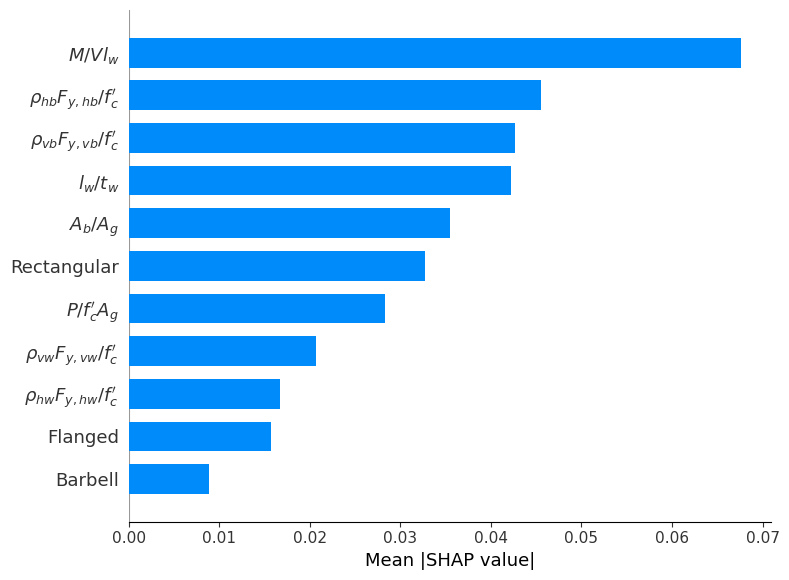

In [17]:
shap_values_overall = np.mean(np.abs(shap_values), axis=2)
shap.summary_plot(shap_values_overall, X, plot_type="bar", show=False)
plt.xlabel("Mean |SHAP value|")
plt.savefig("plots/regular_imp.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

## CVAE

In [18]:
params = {'n_estimators': 328, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.9093561479089233}
model = RandomForestClassifier(**params, random_state=42)
model.fit(X_train_cvae, y_train_cvae)
explainer2 = shap.TreeExplainer(model)

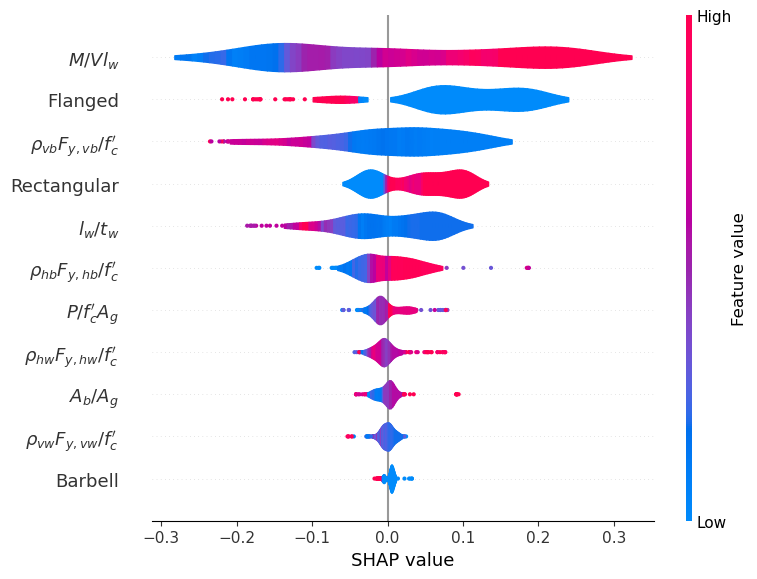

In [19]:
shap_values = explainer2.shap_values(X)
shap_values_class = shap_values[..., 0]
shap.summary_plot(shap_values_class, X, plot_type="violin", show=False)
plt.xlabel("SHAP value")
plt.savefig("plots/cvae_0.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

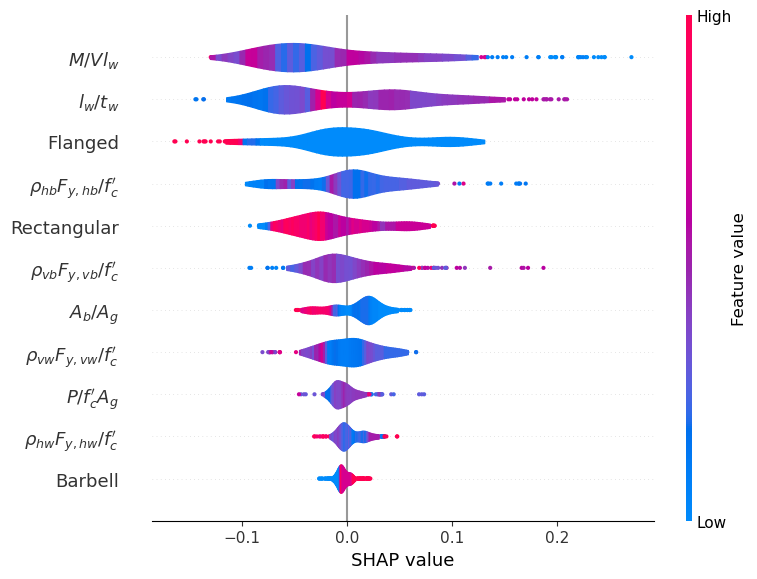

In [20]:
shap_values_class = shap_values[..., 1]
shap.summary_plot(shap_values_class, X, plot_type="violin", show=False)
plt.xlabel("SHAP value")
plt.savefig("plots/cvae_1.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

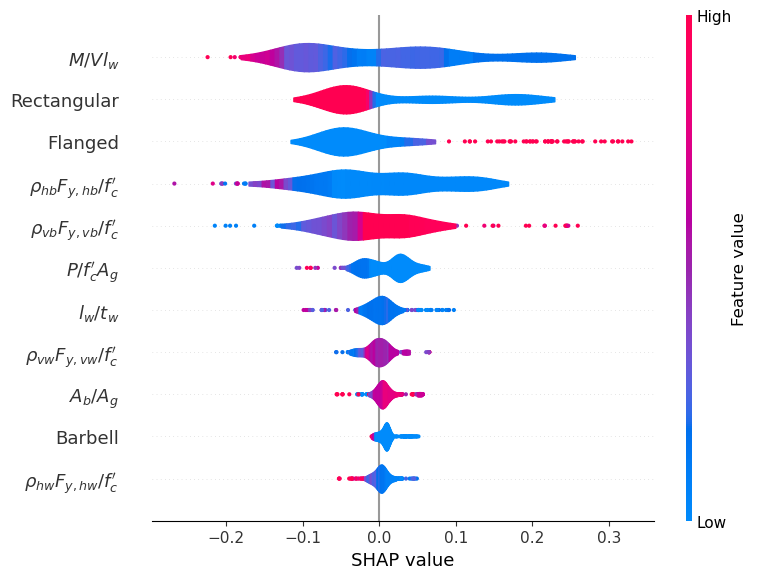

In [21]:
shap_values_class = shap_values[..., 2]
shap.summary_plot(shap_values_class, X, plot_type="violin", show=False)
plt.xlabel("SHAP value")
plt.savefig("plots/cvae_2.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

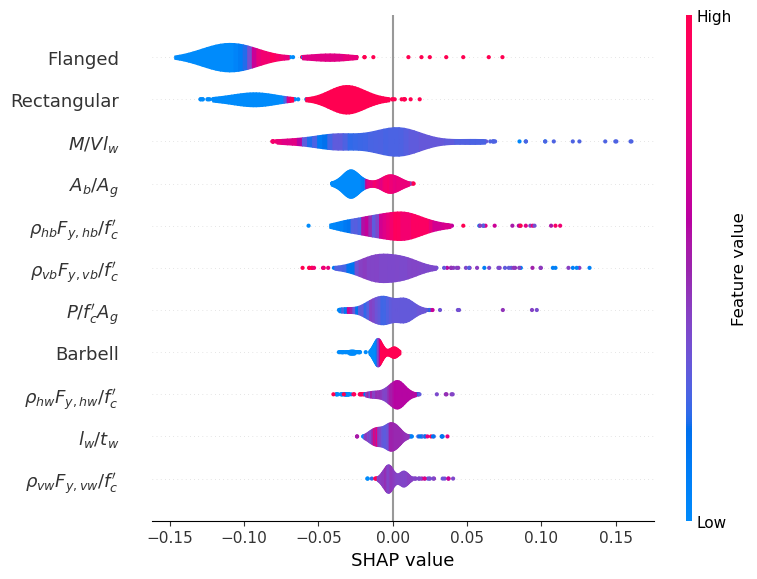

In [22]:
shap_values_class = shap_values[..., 3]
shap.summary_plot(shap_values_class, X, plot_type="violin", show=False)
plt.xlabel("SHAP value")
plt.savefig("plots/cvae_3.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

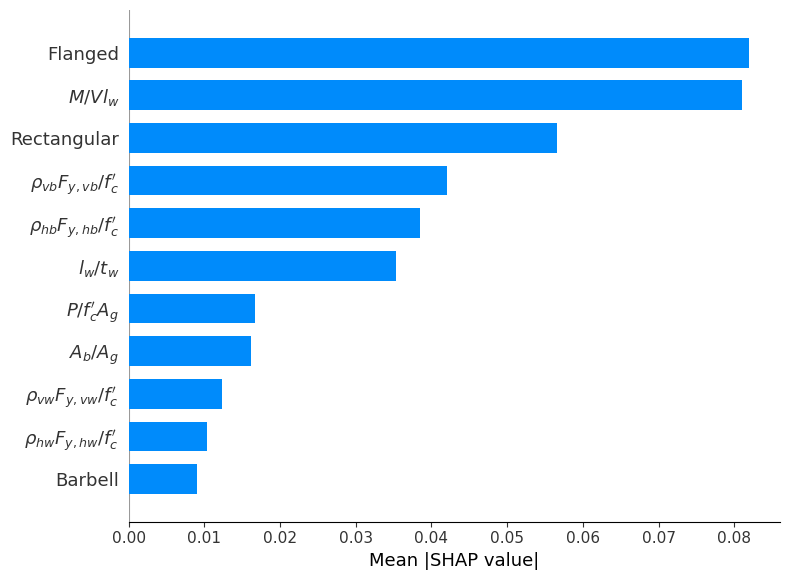

In [23]:
shap_values_overall = np.mean(np.abs(shap_values), axis=2)
shap.summary_plot(shap_values_overall, X, plot_type="bar", show=False)
plt.xlabel("Mean |SHAP value|")
plt.savefig("plots/cvae_imp.jpeg", dpi=600, bbox_inches='tight')  
plt.show()

# New Data

In [24]:
file_path = r'C:\Users\E2-415\Desktop\Databases\Shear_Wall_Database.xlsx'
df2 = pd.read_excel(file_path, sheet_name='Extra')
df_new=df2.loc[:, 'FailureMode':'Ab/Ag']
df_new.head()

FailureMode  M/Vlw  lw/tw  ρvwFy,vw/fc  ρhwFy,hw/fc  ρvbFy,vb/fc  \
0            3   1.25   6.67       0.2794       0.0924       0.9878   
1            3   1.25   6.67       0.2794       0.0924       0.9878   
2            1   1.50  10.00       0.0237       0.1100       0.2253   
3            1   1.50  10.00       0.0263       0.0702       0.2400   
4            1   1.50  10.00       0.0237       0.1100       0.2253   

   ρhbFy,hb/fc  P/fcAg Section  Ab/Ag  
0       0.0000    0.30       R    0.0  
1       0.0000    0.00       R    0.0  
2       0.1307    0.28       R    0.0  
3       0.1076    0.24       R    0.0  
4       0.1307    0.28       R    0.0

In [25]:
df_new.groupby('FailureMode').size()

FailureMode
1    11
2     4
3    15
dtype: int64

In [26]:
print_ranges(df_new)

                 Min       Max
FailureMode        1         3
M/Vlw            0.5       2.5
lw/tw            5.0      12.0
ρvwFy,vw/fc   0.0237    0.2794
ρhwFy,hw/fc  0.02372   0.20829
ρvbFy,vb/fc      0.0  2.510165
ρhbFy,hb/fc      0.0  0.763105
P/fcAg           0.0       0.3
Section            F         R
Ab/Ag            0.0  0.521739


In [27]:
feature=df_new.loc[:, df_new.columns != 'FailureMode']
output=df_new['FailureMode'] - 1
class_names = ["F", "FS", "S", "SL"]

feature_tensor, label_tensor, *_ = process_dataframe(feature, output, existing_info=additional_info)

## CVAE

In [29]:
# train the best model
(X_train, y_train, _, _) = folds_dict['cvae'][0]

params = {'n_estimators': 328, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.9093561479089233}
model = RandomForestClassifier(**params, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=0.9093561479089233,
                       min_samples_leaf=2, min_samples_split=8,
                       n_estimators=328, random_state=42)

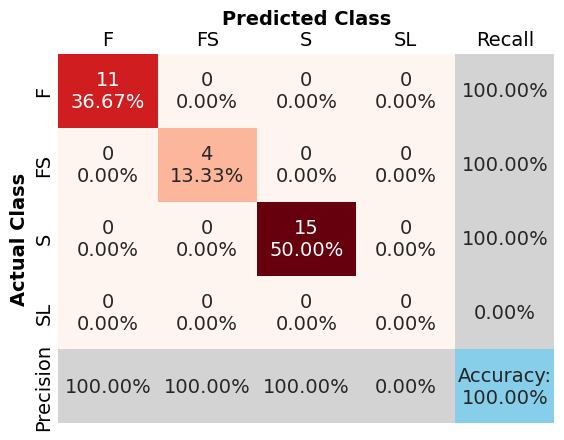

In [30]:
y_pred = model.predict(feature_tensor)
y_true = np.array(output)

_ = extended_confusion_matrix(y_true, y_pred, class_names=class_names, prefix="extra_data")

## Regular

In [28]:
# train the best model
(X_train, y_train, _, _) = folds_dict['regular'][0]

params = {'n_estimators': 425, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.25732930753297395}
model = RandomForestClassifier(**params, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=0.25732930753297395,
                       n_estimators=425, random_state=42)

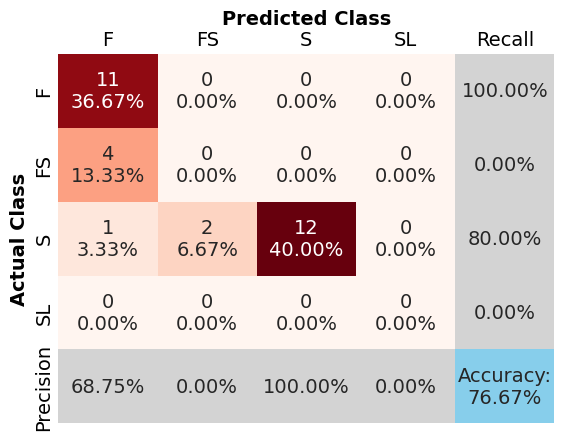

In [29]:
y_pred = model.predict(feature_tensor)
y_true = np.array(output)

_ = extended_confusion_matrix(y_true, y_pred, class_names=class_names, prefix="extra_data_reg")

# Waterfall Plot

In [31]:
x = pd.DataFrame(feature_tensor, columns=col_names).rename(columns=rename_dict)

In [32]:
explaination = explainer2(x)

In [36]:
sample_num = 0

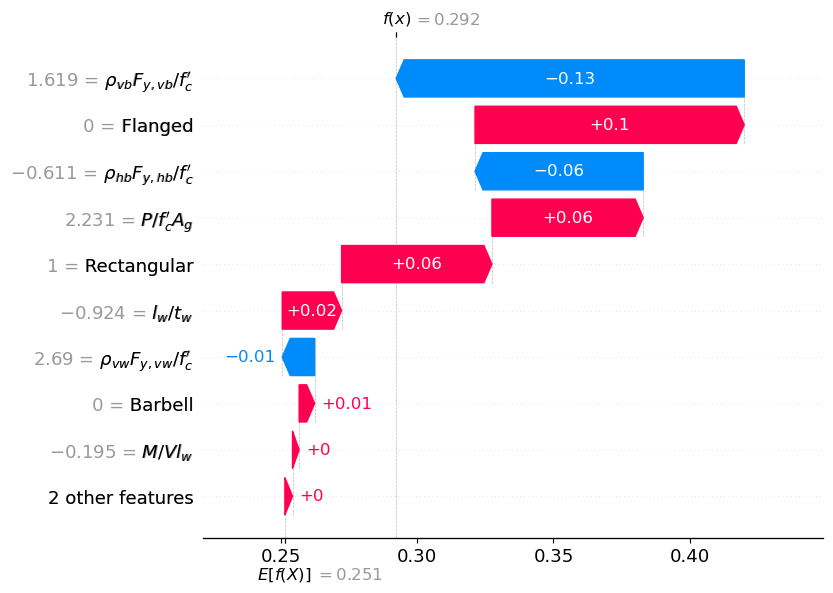

In [37]:
shap.waterfall_plot(explaination[sample_num,:,0])

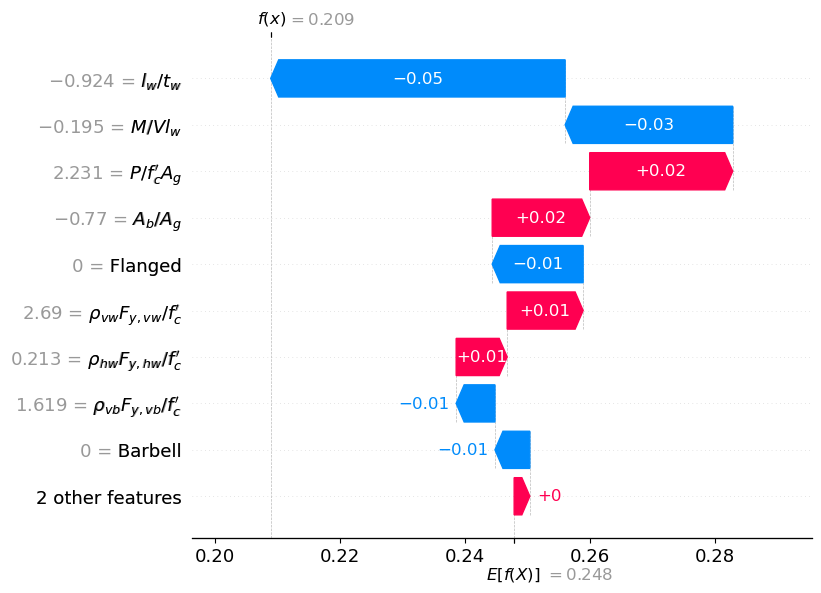

In [38]:
shap.waterfall_plot(explaination[sample_num,:,1])

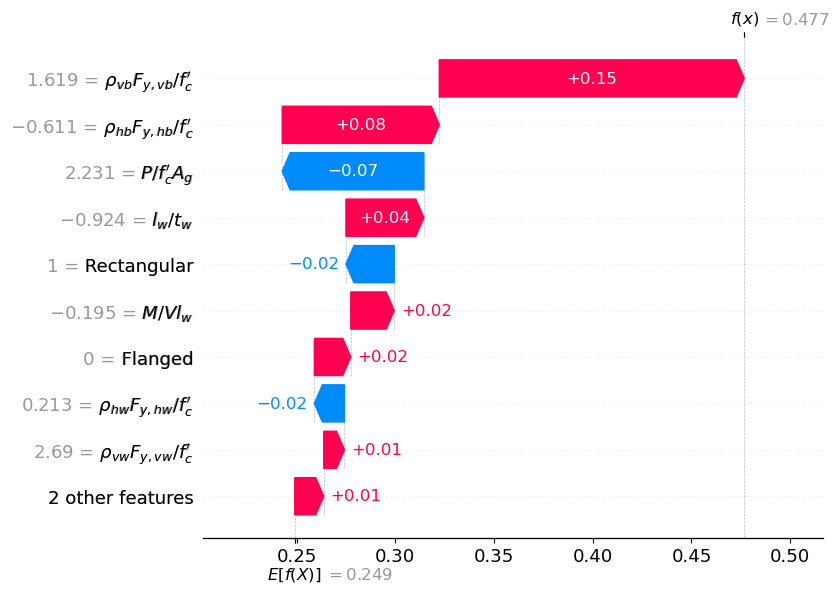

In [39]:
shap.waterfall_plot(explaination[sample_num,:,2])

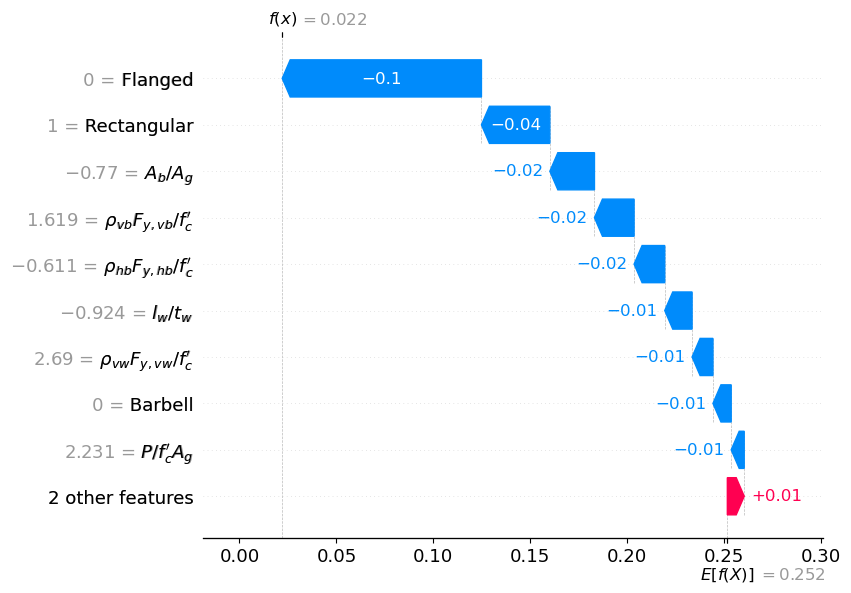

In [40]:
shap.waterfall_plot(explaination[sample_num,:,3])

# RF + CVAE Optimization

In [41]:
(X_train, y_train, X_test, y_test) = folds_dict['cvae'][0]

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())  
study.optimize(lambda trial: objective(trial, "RF", X_train, y_train), n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

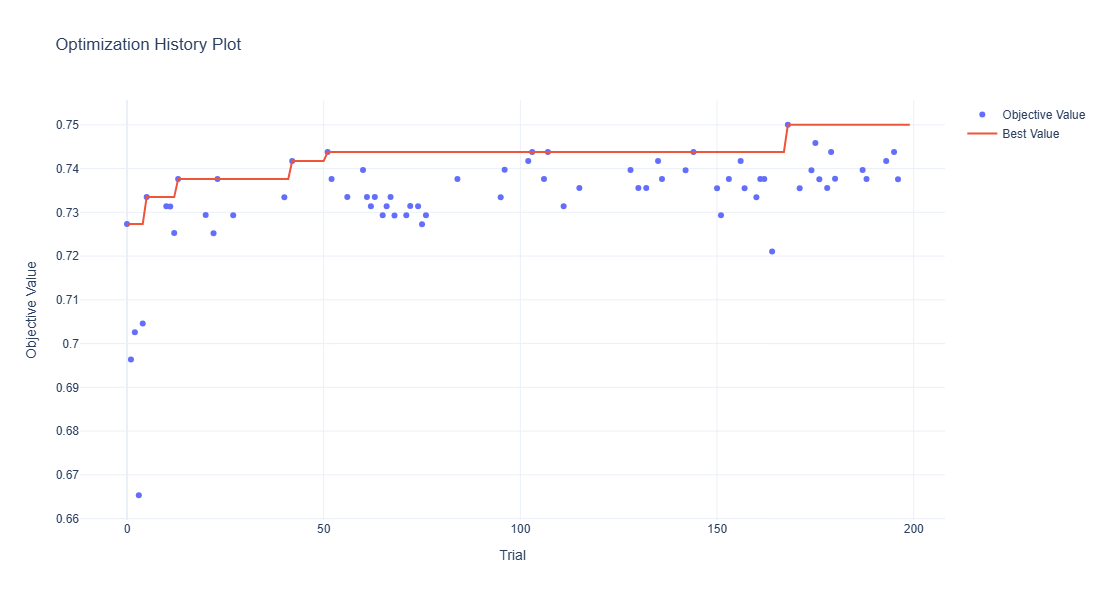

In [45]:
fig=plot_optimization_history(study)

fig.update_layout(
    template='plotly_white',  # White background
    font=dict(family='Arial', size=12),
    coloraxis_colorbar=dict(title='Accuracy'),  # If using color scaling
    width=1000,  # Adjust figure width
    height=600  # Adjust figure height
)

fig.show()

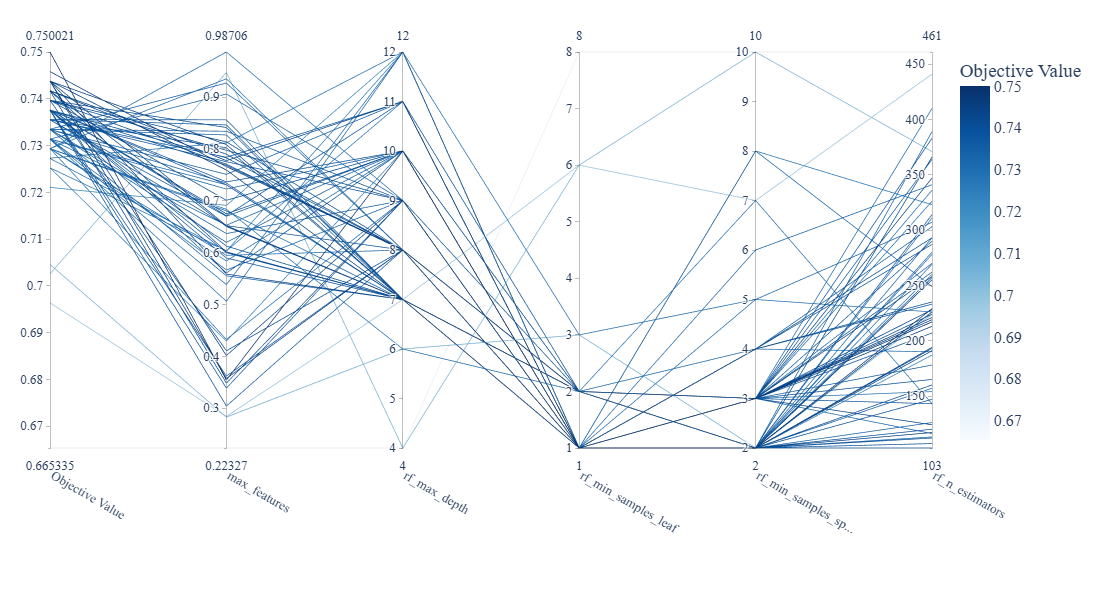

In [46]:
fig = plot_parallel_coordinate(study)
fig.update_layout(
    template='plotly_white',  # White background
    font=dict(family='Times New Roman', size=16),
    width=1000,  # Adjust figure width
    height=600,  # Adjust figure height
    title=None,
    margin=dict(l=50, r=50, t=50, b=150)
)

fig.write_image('plots/parallel plot.jpeg', scale=3)
fig.show()

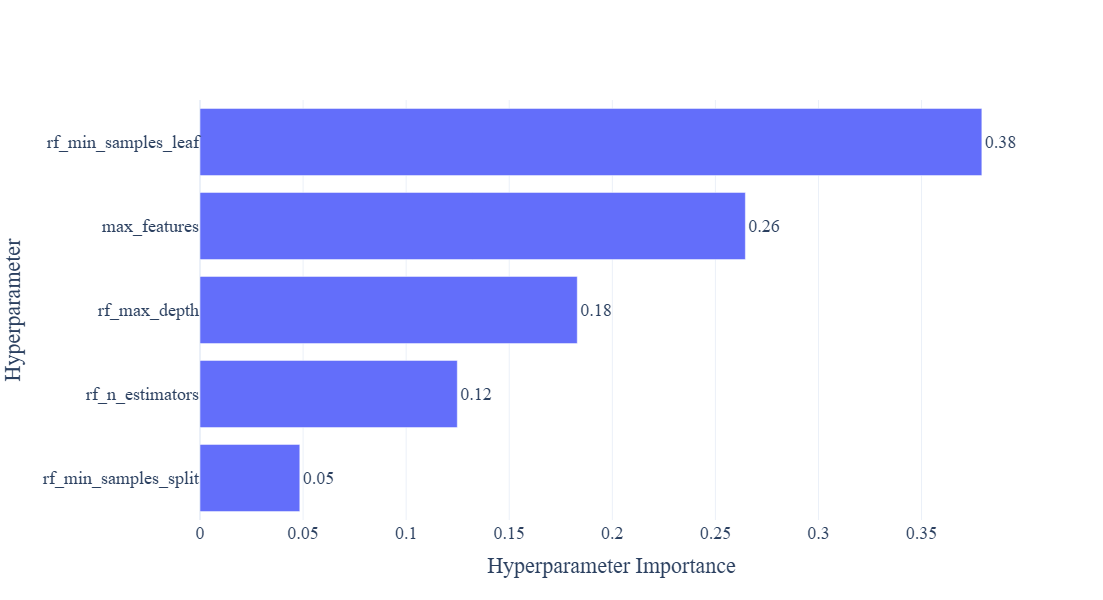

In [47]:
fig = plot_param_importances(study)
fig.update_layout(
    template='plotly_white',  # White background
    font=dict(family='Times New Roman', size=18),
    width=800,  # Adjust figure width
    height=600,  # Adjust figure height
    title=None
)

fig.write_image('plots/param_importance.jpeg', scale=3)
fig.show()